In [1]:
import joblib
import torch
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tiatoolbox.utils.visualization import overlay_prediction_contours
from tiatoolbox.models.engine.nucleus_instance_segmentor import (
    NucleusInstanceSegmentor as InfNucSegmentor,
)
from utils.utils_tumor import color_transfer
from utils.utils_inflams import (
    color_dict_pannuke,
    color_dict_monusac,
    color_dict_consep,
    color_dict_AllInflams,
    get_Inflammatory,
    filter_centroids,
)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("running on", device)

running on cuda:0


In [2]:
img_path = "references/reference7.jpg"  # "sample_tile.png"
img_path = "../data/patches_clr/" + random.choice(
    ["111A", "111B", "111C", "120A", "120B", "120C", "121A"]
)
img_path = img_path + "/" + random.choice(os.listdir(img_path))
print(img_path)
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGRA2RGB)

../data/patches_clr/111C/patch_x_21671_y_27544.jpg


In [3]:
tile_output = InfNucSegmentor(pretrained_model="hovernet_fast-pannuke").predict(
    [img_path],
    mode="tile",
    device=device,
    crash_on_exception=True,
    save_dir="output_pannuke",
)
tile_preds = joblib.load(f"{tile_output[0][1]}.dat")
print("Number of detected nuclei:", len(tile_preds))
overlaid_predictions1 = overlay_prediction_contours(
    draw_dot=False, canvas=img, inst_dict=tile_preds, type_colours=color_dict_pannuke
)
Inflammatory_nucleus1, number1 = get_Inflammatory(tile_preds, color_dict_pannuke)
print("Number of inflammatory cells:", number1)

tile_output = InfNucSegmentor(pretrained_model="hovernet_fast-monusac").predict(
    [img_path],
    mode="tile",
    device=device,
    crash_on_exception=True,
    save_dir="output_monusac",
)
tile_preds = joblib.load(f"{tile_output[0][1]}.dat")
print("Number of detected nuclei: {}".format(len(tile_preds)))
overlaid_predictions2 = overlay_prediction_contours(
    draw_dot=False, canvas=img, inst_dict=tile_preds, type_colours=color_dict_monusac
)
Inflammatory_nucleus2, number2 = get_Inflammatory(tile_preds, color_dict_monusac)
print("Number of inflammatory cells:", number2)

tile_output = InfNucSegmentor(pretrained_model="hovernet_original-consep").predict(
    [img_path],
    mode="tile",
    device=device,
    crash_on_exception=True,
    save_dir="output_consep",
)
tile_preds = joblib.load(f"{tile_output[0][1]}.dat")
print("Number of detected nuclei: {}".format(len(tile_preds)))
overlaid_predictions3 = overlay_prediction_contours(
    draw_dot=False, canvas=img, inst_dict=tile_preds, type_colours=color_dict_consep
)
Inflammatory_nucleus3, number3 = get_Inflammatory(tile_preds, color_dict_consep)
print("Number of inflammatory cells:", number3)

|2025-12-16|09:44:07.167| [WARNING] torch-compile is currently not supported in Python 3.12+.
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Number of detected nuclei: 100
Number of inflammatory cells: 10


|2025-12-16|09:44:09.378| [WARNING] torch-compile is currently not supported in Python 3.12+.
100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Number of detected nuclei: 12
Number of inflammatory cells: 10


|2025-12-16|09:44:10.965| [WARNING] torch-compile is currently not supported in Python 3.12+.
100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

Number of detected nuclei: 104
Number of inflammatory cells: 6


In [4]:
ensembling_dict = {}
for d in (Inflammatory_nucleus1, Inflammatory_nucleus2, Inflammatory_nucleus3):
    ensembling_dict.update(d)
print("Number of inflammatory cells (final):", len(ensembling_dict))

Number of inflammatory cells (final): 26


In [5]:
nuc_centroids = {}
for nuc_id in ensembling_dict:
    centroid = tuple(np.uint8(ensembling_dict[nuc_id]["centroid"]))
    nuc_centroids[centroid] = nuc_id
filtered_centroids = np.array(
    filter_centroids(np.array(list(nuc_centroids.keys())), d_threshold=1.5)
)
filtred_dict = {}
for centroid in filtered_centroids:
    nuc_id = nuc_centroids[tuple(centroid)]
    filtred_dict[nuc_id] = ensembling_dict[nuc_id]
print("Number of inflammatory cells (final after filteration):", len(filtred_dict))
overlaid_predictions123 = overlay_prediction_contours(
    canvas=img,
    inst_dict=filtred_dict,
    type_colours=color_dict_AllInflams,
    draw_dot=False,
)

  0%|          | 0/22 [00:00<?, ?it/s]

Number of inflammatory cells (final after filteration): 21


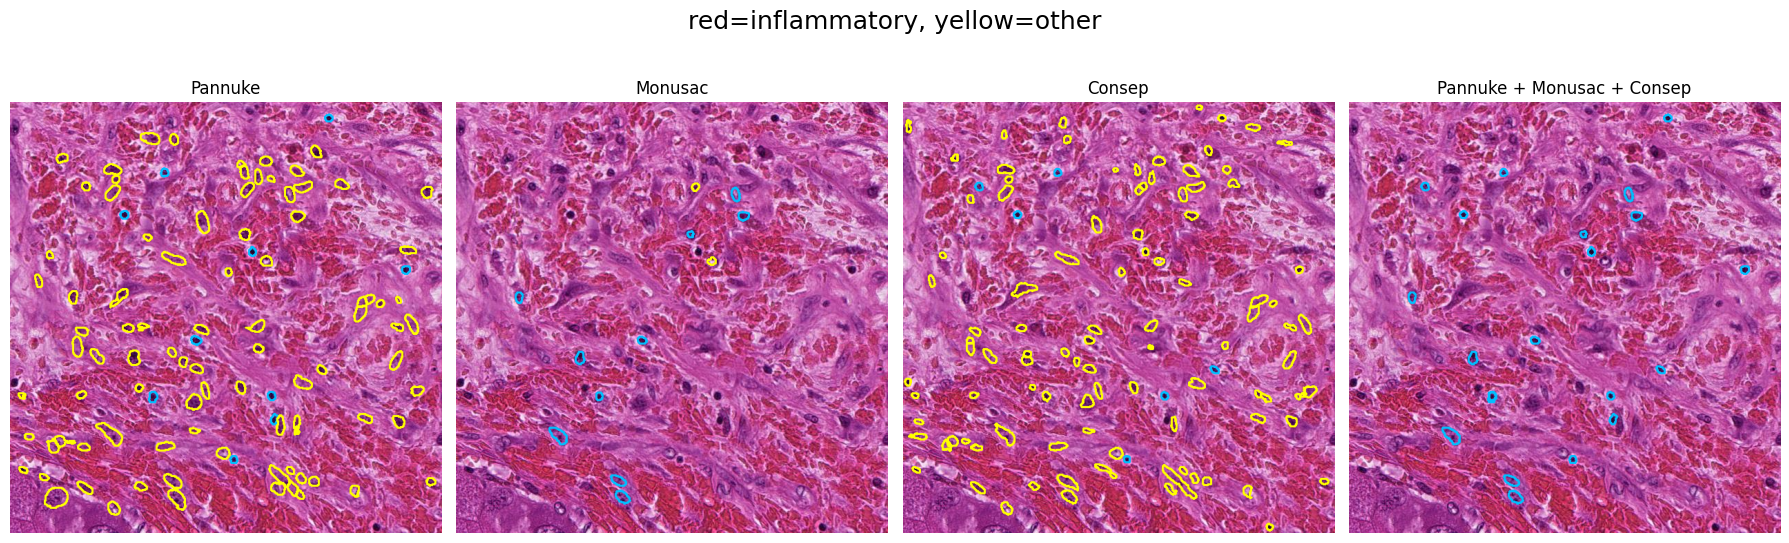

In [6]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle("red=inflammatory, yellow=other", fontsize=18)
ax1 = plt.subplot(1, 4, 1), plt.imshow(overlaid_predictions1), plt.axis("off")
plt.title("Pannuke")
ax2 = plt.subplot(1, 4, 2), plt.imshow(overlaid_predictions2), plt.axis("off")
plt.title("Monusac")
ax3 = plt.subplot(1, 4, 3), plt.imshow(overlaid_predictions3), plt.axis("off")
plt.title("Consep")
ax4 = plt.subplot(1, 4, 4), plt.imshow(overlaid_predictions123), plt.axis("off")
plt.title("Pannuke + Monusac + Consep")
plt.tight_layout()
plt.show()